In [ ]:
!apt update && apt install ffmpeg libsm6 libxext6  -y
!pip install -U scikit-image
!pip install opencv-python
!pip install opencv-contrib-python

Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://security.debian.org/debian-security buster/updates InRelease [65.4 kB]
Get:3 http://deb.debian.org/debian buster-updates InRelease [51.9 kB]
Get:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [308 kB]
Get:5 http://deb.debian.org/debian buster/main amd64 Packages [7,906 kB]
Get:6 http://deb.debian.org/debian buster-updates/main amd64 Packages [15.2 kB]
Fetched 8,469 kB in 4s (2,134 kB/s)



2 packages can be upgraded. Run 'apt list --upgradable' to see them.



libsm6 is already the newest version (2:1.2.3-1).
libsm6 set to manually installed.
libxext6 is already the newest version (2:1.3.3-1+b2).
libxext6 set to manually installed.
The following additional packages will be installed:
  i965-va-driver intel-media-va-driver libaacs0 libaom0 libasound2
  libasound2-data libass9 libasyncns0 libavc1394-0 libavcodec58 libavdevice58
  libavfilter7 libavformat58 libavresample4 libavutil56

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import sklearn
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import os
#from pytorchsuperpointmaster.models.SuperPointNet_pretrained import SuperPointNet
from PIL import Image

In [2]:
im_castle_1 = 'hpatches-sequences-release/i_castle/1.ppm'
im_castle_6 = 'hpatches-sequences-release/i_castle/6.ppm'
im_lion_1 = 'hpatches-sequences-release/i_lionnight/1.ppm'
im_lion_3 = 'hpatches-sequences-release/i_lionnight/3.ppm'


fold = 'hpatches-sequences-release'
im_set_i = list(filter(lambda x: x[0] == 'i', os.listdir(fold)))[:10]
im_set_v = list(filter(lambda x: x[0] == 'v', os.listdir(fold)))[:10]

def computeSeries(im_set, computeFunc, extractor):
    fold = 'hpatches-sequences-release'

    res = 0
    c = 1
    for name in im_set:
        print(f'\r{c}/{len(im_set)}',end='')
        path = f"{fold}/{name}/"
        im1 = path + '1.ppm'
        images = [path+str(i)+'.ppm' for i in range(2,7)]
        H = [np.loadtxt(path + 'H_1_'+str(i)) for i in range(2,7)]

        for im,h in zip(images,H):
            res += computeFunc(*extractor(im1, im, h))
        c+=1

    return res/(len(im_set)*5)

In [3]:
def computeSeriesLE(im_set, computeFunc, extractor, eps):
    fold = 'hpatches-sequences-release'

    res = 0
    c = 1
    for name in im_set:
        print(f'\r{c}/{len(im_set)}',end='')
        path = f"{fold}/{name}/"
        im1 = path + '1.ppm'
        images = [path+str(i)+'.ppm' for i in range(2,7)]
        H = [np.loadtxt(path + 'H_1_'+str(i)) for i in range(2,7)]

        for im,h in zip(images,H):
            t = computeFunc(*extractor(im1, im, h))
            res += t if t > 0.01 else eps
        c+=1

    return res/(len(im_set)*5)

In [4]:
def computeSeriesH(im_set, computeFunc, extractor):
    fold = 'hpatches-sequences-release'

    res = 0
    c = 1
    for name in im_set:
        print(f'\r{c}/{len(im_set)}',end='')
        path = f"{fold}/{name}/"
        im1 = path + '1.ppm'
        images = [path+str(i)+'.ppm' for i in range(2,7)]
        H = [np.loadtxt(path + 'H_1_'+str(i)) for i in range(2,7)]

        for im,h in zip(images,H):
            res += (computeFunc(*extractor(im1, im, h)) <= 1)
        c+=1

    return res/(len(im_set)*5)

In [29]:

eps = 1
res = computeSeries(im_set_i+im_set_v, computeDescriptors, lambda im1, im2, _: ['SURF', im1, im2, 1])
#res = computeSeriesLE(im_set_i+im_set_v, computeLocalizationError, lambda im1, im2, h: ['SIFT', im1, im2, eps, h], eps)
#res = computeSeriesH(im_set_i+im_set_v, computeHomographyError, lambda im1, im2, h: ['ORB', im1, im2, h])
print('\n',res)

20/20
 0.49782334003833434


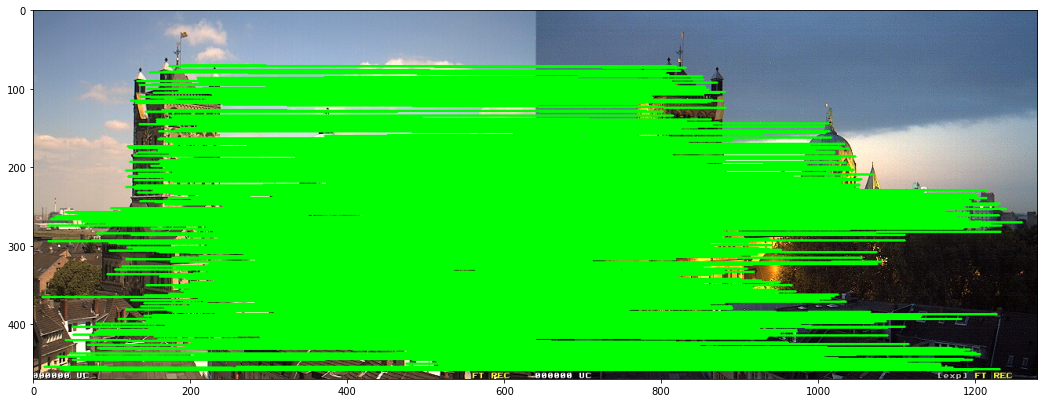

In [31]:
def computeTrueMatches(descriptor,img1,img2,eps,homography=None):
    #-- Step 0: Load images
    im1 = plt.imread(img1)
    #im1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    im2 = plt.imread(img2)
    #im2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
    im = np.concatenate((im1,im2),axis=1).astype(np.uint8)
    #-- Step 1: Detect the keypoints using SURF Detector, compute the descriptors
    if(descriptor == 'SIFT'):
        detector = cv2.xfeatures2d.SIFT_create()
    elif(descriptor == 'SURF'):
        detector = cv2.xfeatures2d.SURF_create(400)
    elif(descriptor == 'ORB'):
        detector = cv2.ORB_create()
    kp1, _ = detector.detectAndCompute(im1, None)
    kp2, _ = detector.detectAndCompute(im2, None)
    kp1 = np.array(list(map(lambda x: [x.pt[0], x.pt[1]], kp1)))
    kp2 = np.array(list(map(lambda x: [x.pt[0], x.pt[1]], kp2)))
    if(homography is not None):
        X = kp1[:,0]
        Y = kp1[:,1]
        ones = np.ones_like(X)
        points = np.stack((X,Y,ones),axis=0)
        transformed = homography@points
        kp1 = np.array([transformed[:2,i] for i in range(points.shape[1])])
    
    neigh = NearestNeighbors(n_neighbors=1,radius=eps)
    neigh = neigh.fit(kp1)
    kp1_idx = np.zeros(len(kp1))
    matches = []
    dist, idx = neigh.radius_neighbors(kp2,return_distance=True,sort_results=True)
    for n,i_arr,dist_arr in zip(range(len(idx)),idx,dist):
        for i,d in zip(i_arr,dist_arr):
            if kp1_idx[i] == 0:
                kp1_idx[i] = 1
                matches.append([n,i])
                break
                
    for match in matches:
        p2 = (int(kp2[match[0]][0] + im1.shape[1]),int(kp2[match[0]][1]))
        p1 = (int(kp1[match[1]][0]),int(kp1[match[1]][1]))
        out = cv2.line(im,p1,p2,(0,255,0),2)
        
    
    plt.figure(figsize=(18,36))
    plt.imshow(out)
computeTrueMatches('SURF',im_castle_1,im_castle_6,5,homography=None)

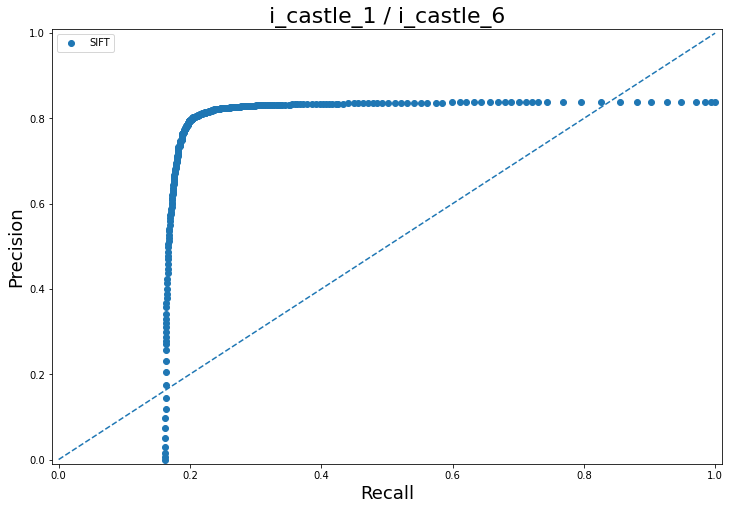

In [ ]:

plt.figure(figsize=(12,8))
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),linestyle='dashed')
plt.scatter((1-res[1])[::-1],res[0],label='SIFT')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.xlabel('Recall',fontsize=18)
plt.ylabel('Precision',fontsize=18)
plt.title('i_castle_1 / i_castle_6',fontsize=22)
plt.legend()
plt.show()

In [ ]:
def computeMatches(descriptor,img1,img2):
    #-- Step 0: Load images
    im1 = cv2.imread(img1)
    im1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    im2 = cv2.imread(img2)
    im2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
    #-- Step 1: Detect the keypoints using SURF Detector, compute the descriptors
    if(descriptor == 'SIFT'):
        detector = cv2.xfeatures2d.SIFT_create()
    elif(descriptor == 'SURF'):
        detector = cv2.xfeatures2d.SURF_create(400)
    elif(descriptor == 'ORB'):
        detector = cv2.ORB_create()
    keypoints1, descriptors1 = detector.detectAndCompute(im1, None)
    keypoints2, descriptors2 = detector.detectAndCompute(im2, None)
    descriptors1 = np.float32(descriptors1)
    descriptors2 = np.float32(descriptors2)
    #-- Step 2: Matching descriptor vectors with a FLANN based matcher
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    knn_matches = matcher.knnMatch(descriptors1, descriptors2, 2)
    #-- Filter matches using the Lowe's ratio test
    ratio_thresh = 0.7
    good_matches = []
    for m,n in knn_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    #-- Draw matches
    img_matches = np.empty((max(im1.shape[0], im2.shape[0]), im1.shape[1]+im2.shape[1], 3), dtype=np.uint8)
    cv2.drawMatches(im1, keypoints1, im2, keypoints2, good_matches, img_matches, 2, matchColor=-1, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    #cv2.drawMatches(im1, keypoints1, im2, keypoints2, good_matches, img_matches, -1, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    #-- Show detected matches
    plt.figure(figsize=(18,36))
    plt.imshow(img_matches)

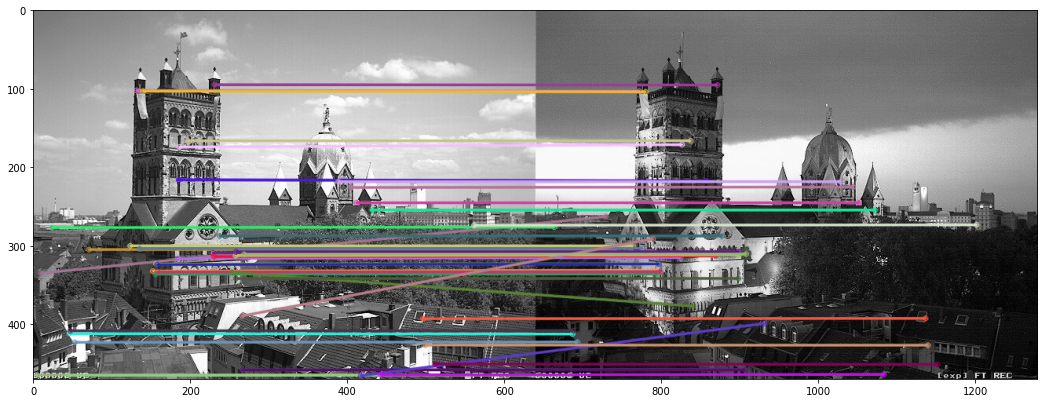

In [ ]:
computeMatches('SIFT',im_castle_1,im_castle_6)

In [ ]:
def computeKeypoints(descriptor,img1,img2,max_eps):
    #-- Step 0: Load images
    im1 = cv2.imread(img1)
    im1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    im2 = cv2.imread(img2)
    im2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
    #-- Step 1: Detect the keypoints using SURF Detector, compute the descriptors
    if(descriptor == 'SIFT'):
        detector = cv2.xfeatures2d.SIFT_create()
    elif(descriptor == 'SURF'):
        detector = cv2.xfeatures2d.SURF_create(400)
    elif(descriptor == 'ORB'):
        detector = cv2.ORB_create()
    kp1, _ = detector.detectAndCompute(im1, None)
    kp2, _ = detector.detectAndCompute(im2, None)
    kp1 = np.array(list(map(lambda x: [x.pt[0], x.pt[1]], kp1)))
    kp2 = np.array(list(map(lambda x: [x.pt[0], x.pt[1]], kp2)))
    points = 400
    
    epsilons = []
    for eps in np.linspace(0,max_eps,points):
        print(f'\r{(eps/max_eps)*50:.2f}%',end='')
        neigh = NearestNeighbors(n_neighbors=1,radius=eps)
        neigh = neigh.fit(kp1)
        precision = np.zeros(len(kp1))
        _, idx = neigh.radius_neighbors(kp2,return_distance=True,sort_results=True)
        for i_arr in idx:
            for i in i_arr:
                if precision[i] == 0:
                    precision[i] = 1
                    break

        epsilons.append(precision)
    
    epsilons = np.array(epsilons)
    precisions = [np.sum(epsilons[i])/len(kp2) for i in range(epsilons.shape[0])]


    epsilons = []
    for eps in np.linspace(0,max_eps,points):
        print(f'\r{(eps/max_eps)*50+50:.2f}%',end='')
        neigh = NearestNeighbors(n_neighbors=1,radius=eps)
        neigh = neigh.fit(kp2)
        recall = np.zeros(len(kp2))
        _, idx = neigh.radius_neighbors(kp1,return_distance=True,sort_results=True)
        for i_arr in idx:
            for i in i_arr:
                if recall[i] == 0:
                    recall[i] = 1
                    break
        epsilons.append(recall)
    epsilons = np.array(epsilons)
    recalls = [epsilons[i].mean() for i in range(epsilons.shape[0])]
    
    #return precisions, recalls
    return sklearn.metrics.auc((1-np.array(recalls))[::-1], precisions)

In [23]:
def computeLocalizationError(descriptor,img1,img2,eps,homography=None):
    #-- Step 0: Load images
    im1 = cv2.imread(img1)
    im1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    im2 = cv2.imread(img2)
    im2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
    #-- Step 1: Detect the keypoints using SURF Detector, compute the descriptors
    if(descriptor == 'SIFT'):
        detector = cv2.xfeatures2d.SIFT_create()
    elif(descriptor == 'SURF'):
        detector = cv2.xfeatures2d.SURF_create()
    elif(descriptor == 'ORB'):
        detector = cv2.ORB_create()
    kp1, _ = detector.detectAndCompute(im1, None)
    kp2, _ = detector.detectAndCompute(im2, None)
    kp1 = np.array(list(map(lambda x: [x.pt[0], x.pt[1]], kp1)))
    kp2 = np.array(list(map(lambda x: [x.pt[0], x.pt[1]], kp2)))
    if(homography is not None):
        X = kp1[:,0]
        Y = kp1[:,1]
        ones = np.ones_like(X)
        points = np.stack((X,Y,ones),axis=0)
        transformed = homography@points
        kp1 = np.array([transformed[:2,i] for i in range(points.shape[1])])
    
    LE = 0
    neigh = NearestNeighbors(n_neighbors=1,radius=eps)
    neigh = neigh.fit(kp1)
    precision = np.zeros(len(kp1))
    dist, idx = neigh.radius_neighbors(kp2,return_distance=True,sort_results=True)
    for i_arr,dist_arr in zip(idx,dist):
        for i,d in zip(i_arr,dist_arr):
            if precision[i] == 0:
                precision[i] = 1
                LE += d
                break
    
    return LE/(precision.sum() + 1e-10)

In [28]:
def computeDescriptors(descriptor,img1,img2,max_eps):
    #-- Step 0: Load images
    im1 = cv2.imread(img1)
    im1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    im2 = cv2.imread(img2)
    im2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
    #-- Step 1: Detect the keypoints using SURF Detector, compute the descriptors
    if(descriptor == 'SIFT'):
        detector = cv2.xfeatures2d.SIFT_create()
    elif(descriptor == 'SURF'):
        detector = cv2.xfeatures2d.SURF_create()
    elif(descriptor == 'ORB'):
        detector = cv2.ORB_create(nfeatures=1000000)
    _,des1 = detector.detectAndCompute(im1, None)
    _,des2 = detector.detectAndCompute(im2, None)
    des1 = np.array(des1)
    des2 = np.array(des2)
    
    if des1.shape[0] > 1000:
        des1 = des1[:1000,...]
    if des2.shape[0] > 1000:
        des2 = des2[:1000,...]
    
    points = 100
    
    epsilons = []
    for eps in np.linspace(0,max_eps,points):
        #print(f'\r{(eps/max_eps)*50:.2f}%',end='')
        neigh = NearestNeighbors(n_neighbors=1,radius=eps)
        neigh = neigh.fit(des1)
        precision = np.zeros(len(des1))
        _, idx = neigh.radius_neighbors(des2,return_distance=True,sort_results=True)
        for i_arr in idx:
            for i in i_arr:
                if precision[i] == 0:
                    precision[i] = 1

                    break

        epsilons.append(precision)
    
    epsilons = np.array(epsilons)
    precisions = [np.sum(epsilons[i])/len(des2) for i in range(epsilons.shape[0])]


    epsilons = []
    for eps in np.linspace(0,max_eps,points):
        #print(f'\r{(eps/max_eps)*50+50:.2f}%',end='')
        neigh = NearestNeighbors(n_neighbors=1,radius=eps)
        neigh = neigh.fit(des2)
        recall = np.zeros(len(des2))
        _, idx = neigh.radius_neighbors(des1,return_distance=True,sort_results=True)
        for i_arr in idx:
            for i in i_arr:
                if recall[i] == 0:
                    recall[i] = 1
                    break
        epsilons.append(recall)
    epsilons = np.array(epsilons)
    recalls = [np.sum(epsilons[i])/len(des1) for i in range(epsilons.shape[0])]

    precisions /= np.max(precisions)
    recalls /= np.max(recalls)
    return sklearn.metrics.auc((1-np.array(recalls)), precisions)
    
    #return precisions, recalls

In [22]:
def computeHomographyError(descriptor,img1,img2,h_hat):
    #-- Step 0: Load images
    im1 = cv2.imread(img1)
    im1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    im2 = cv2.imread(img2)
    im2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
    #-- Step 1: Detect the keypoints using SURF Detector, compute the descriptors
    if(descriptor == 'SIFT'):
        detector = cv2.xfeatures2d.SIFT_create()
    elif(descriptor == 'SURF'):
        detector = cv2.xfeatures2d.SURF_create()
    elif(descriptor == 'ORB'):
        detector = cv2.ORB_create()

    keypoints1, descriptors1 = detector.detectAndCompute(im1, None)
    keypoints2, descriptors2 = detector.detectAndCompute(im2, None)
    descriptors1 = np.float32(descriptors1)
    descriptors2 = np.float32(descriptors2)
    #-- Step 2: Matching descriptor vectors with a FLANN based matcher
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    knn_matches = matcher.knnMatch(descriptors1, descriptors2, 2)
    ratio_thresh = 1.
    good_matches = [] # threshold to len 1000 - superpoint paper
    for m,n in knn_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    src = np.array([keypoints1[good_matches[i].queryIdx].pt for i in range(len(good_matches))])
    dst = np.array([keypoints2[good_matches[i].trainIdx].pt for i in range(len(good_matches))])

    # knn_matches = np.array(matcher.knnMatch(descriptors1, descriptors2, 1))
    # src = np.array([keypoints1[knn_matches[i,0].queryIdx].pt for i in range(len(knn_matches))])
    # dst = np.array([keypoints2[knn_matches[i,0].trainIdx].pt for i in range(len(knn_matches))])

    h_true,_ = cv2.findHomography(src,dst,cv2.RANSAC)

    corners = np.array([[0,0],[0,im1.shape[1]],[im1.shape[0],0],[im1.shape[0],im1.shape[1]]])

    X = corners[:,0]
    Y = corners[:,1]
    ones = np.ones_like(X)
    points = np.stack((X,Y,ones),axis=0)
    t_hat = h_hat@points
    t_true = h_true@points
    c_hat = np.array([t_hat[:2,i] for i in range(points.shape[1])])
    c_true = np.array([t_true[:2,i] for i in range(points.shape[1])])
    
    return np.abs(c_true - c_hat).sum()/4

In [ ]:
h = np.identity(3)
print(computeHomographyError('SIFT',im_lion_1,im_lion_3,h))

2.4636623428781483


In [21]:
computeDescriptors('SURF',im_lion_1,im_lion_3,900)

(2522, 64)


1.0

# Feature points

SIFT:
100.00%
ORB:
100.00%

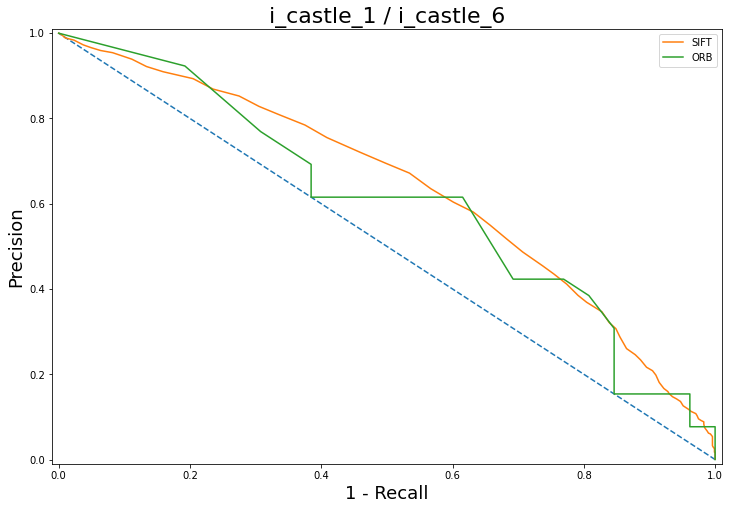

In [ ]:
print('SIFT:')
siftP, siftR = computeDescriptors('SIFT',im_castle_1,im_castle_6,400)
print('\nORB:')
orbP, orbR = computeDescriptors('ORB',im_castle_1,im_castle_6,300)
#print('\nSURF:')
#surfP, surfR = computeKeypoints('SURF',im_castle_1,im_castle_6,50)
plt.figure(figsize=(12,8))
plt.plot(np.linspace(0,1,10)[::-1],np.linspace(0,1,10),linestyle='dashed')
plt.plot((1-np.array(siftR)),siftP,label='SIFT')
plt.plot((1-np.array(orbR)),orbP,label='ORB')
# plt.plot(surfR,surfP,label='SURF')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.xlabel('1 - Recall',fontsize=18)
plt.ylabel('Precision',fontsize=18)
plt.title('i_castle_1 / i_castle_6',fontsize=22)
plt.legend()
plt.show()

In [ ]:
print(sklearn.metrics.auc((1-np.array(orbR)), orbP))
print(sklearn.metrics.auc((1-np.array(siftR)), siftP))
print(sklearn.metrics.auc(np.linspace(0,1,10), np.linspace(0,1,10)))

0.602810650887574
0.6348044369135376
0.5


In [ ]:
print((1-np.array(siftR))[::-1][0],(1-np.array(siftR))[::-1][-1])
print((1-np.array(orbR))[::-1][0],(1-np.array(orbR))[::-1][-1])

0.04491017964071853 1.0
0.28600000000000003 0.928


In [ ]:
def area_under_curve(recalls, precisions):
    recalls, precisions = np.array(recalls), np.array(precisions)
    dr = recalls[1:]-recalls[:-1]
    print(dr.sum())
    dp = dr*precisions[1:]
    return np.sum(dp)


print(area_under_curve((1-np.array(orbR))[::-1], orbP))
print('')
print(area_under_curve((1-np.array(siftR))[::-1], siftP))

0.928
0.92704

0.998003992015968
0.9926832960824856


In [ ]:
h = np.identity(3)
print(computeLocalizationError('SIFT',im_lion_1,im_lion_3,4,homography=h))
print(computeLocalizationError('SIFT',im_lion_1,im_lion_3,4,homography=None))

2.2193740319051476
2.2193740319051476


# Descriptors

SIFT:
100.00%
ORB:
96.87%100.00%

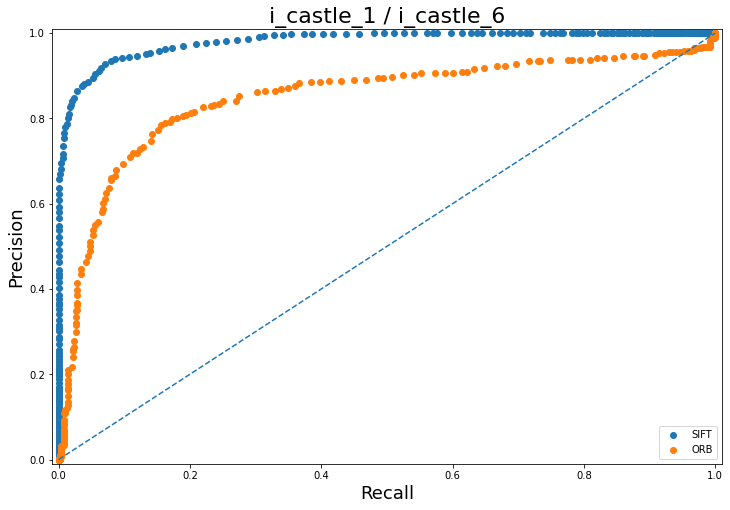

In [ ]:
print('SIFT:')
siftP, siftR = computeDescriptors('SIFT',im_castle_1,im_castle_6,700) #500
print('\nORB:')
orbP, orbR = computeDescriptors('ORB',im_castle_1,im_castle_6,800) #700
#print('\nSURF:')
#surfP, surfR = computeKeypoints('SURF',im_castle_1,im_castle_6,50)
plt.figure(figsize=(12,8))
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),linestyle='dashed')
plt.scatter((1-np.array(siftR))[::-1],siftP,label='SIFT')
plt.scatter((1-np.array(orbR))[::-1],orbP,label='ORB')
# plt.plot(surfR,surfP,label='SURF')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.xlabel('Recall',fontsize=18)
plt.ylabel('Precision',fontsize=18)
plt.title('i_castle_1 / i_castle_6',fontsize=22)
plt.legend()
plt.show()

In [ ]:
print(sklearn.metrics.auc((1-np.array(orbR))[::-1], orbP))
print(sklearn.metrics.auc((1-np.array(siftR))[::-1], siftP))
print(sklearn.metrics.auc(np.linspace(0,1,10), np.linspace(0,1,10)))

0.848262
0.9808407137820169
0.5


In [ ]:
print((1-np.array(siftR))[::-1][0],(1-np.array(siftR))[::-1][-1])
print((1-np.array(orbR))[::-1][0],(1-np.array(orbR))[::-1][-1])

0.0 1.0
0.0 1.0


### Scaling:
    v_there

# Test code

In [ ]:
im1 = cv2.imread(im_lion_1)
im1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
im2 = cv2.imread(im_lion_3)
im2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
detector = cv2.ORB_create()
kp1,_ = detector.detectAndCompute(im1, None)
kp2,_ = detector.detectAndCompute(im2, None)
kp1 = np.array(list(map(lambda x: [x.pt[0], x.pt[1]], kp1)))
kp2 = np.array(list(map(lambda x: [x.pt[0], x.pt[1]], kp2)))
eps = 1
neigh = NearestNeighbors(n_neighbors=1,radius=eps)
neigh = neigh.fit(kp1)
dist, idx = neigh.radius_neighbors(kp2, return_distance=True,sort_results=True)
print(dist)


[array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([0.95295105]) array([], dtype=float64)
 array([1.]) array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([0.92813523]) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64) array([1.])
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=float64) array([], dtype=float64)
 array([], dtype=f

In [ ]:
recall = np.zeros(len(kp2))

for i_arr in idx:
    for i in i_arr:
        if recall[i] == 0:
            recall[i] = 1
            break


In [ ]:
def closest_node_index(node, nodes):
    index = cdist([node], nodes).argmin()
    return index

final = []
for arr in kp2:
    i = closest_node_index(arr, kp1)
    final.append(kp1[i])
    kp1 = np.delete(kp1, i, axis=0)


In [ ]:
final

[array([125., 184.]),
 array([166.80000305, 211.20001221]),
 array([137.3553009 , 110.48143768]),
 array([286.84802246, 357.69604492]),
 array([179.15908813, 353.34152222]),
 array([260., 362.]),
 array([126.00000763, 186.        ]),
 array([246.34373474, 375.73641968]),
 array([302.40002441, 297.21603394]),
 array([109.44000244, 264.96002197]),
 array([266., 361.]),
 array([211.68000793, 275.04000854]),
 array([126., 186.]),
 array([495.67346191, 250.82272339]),
 array([166.80000305, 208.80000305]),
 array([497.6640625 , 252.97923279]),
 array([442.80001831, 241.20001221]),
 array([246.75843811, 375.32165527]),
 array([431.30886841, 246.75843811]),
 array([298.59848022, 295.61248779]),
 array([578.88006592, 274.75201416]),
 array([167.61601257, 167.61601257]),
 array([212., 392.]),
 array([224., 304.]),
 array([286.55999756, 362.88000488]),
 array([179.15908813, 349.36022949]),
 array([237., 241.]),
 array([224.40000916, 304.80001831]),
 array([298., 296.]),
 array([200.40000916, 331.

In [ ]:
res

(array([array([4.24264069]), array([], dtype=float64), array([4.87523203]),
        array([3.68823727, 3.21991605, 2.57590009, 3.21994335, 3.68828016]),
        array([], dtype=float64), array([1.]),
        array([3.60555128, 1.41420817, 1.41421356]),
        array([], dtype=float64), array([3.15315841, 3.9337533 ]),
        array([], dtype=float64), array([5.]), array([], dtype=float64),
        array([5.        , 3.16227042, 3.16227766]),
        array([], dtype=float64), array([], dtype=float64),
        array([], dtype=float64), array([], dtype=float64),
        array([], dtype=float64), array([], dtype=float64),
        array([], dtype=float64), array([], dtype=float64),
        array([], dtype=float64), array([], dtype=float64),
        array([0.        , 0.89444766]), array([1.]),
        array([], dtype=float64),
        array([3.49581345, 2.56123206, 1.41421356, 2.3866196 ]),
        array([2.82842712, 2.68328157, 4.3642796 , 4.76386539, 4.55618849]),
        array([], dtype=

In [ ]:
def nnKeyPoints(descriptor,img1,img2,max_eps):
    #-- Step 0: Load images
    im1 = cv2.imread(img1)
    im1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    im2 = cv2.imread(img2)
    im2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
    #-- Step 1: Detect the keypoints using SURF Detector, compute the descriptors
    if(descriptor == 'SIFT'):
        detector = cv2.xfeatures2d.SIFT_create()
    elif(descriptor == 'SURF'):
        detector = cv2.xfeatures2d.SURF_create(400)
    elif(descriptor == 'ORB'):
        detector = cv2.ORB_create()
    kp1, _ = detector.detectAndCompute(im1, None)
    kp2, _ = detector.detectAndCompute(im2, None)
    
    nn = NearestNeighbors(n_neighbors=1)
    kp1 = np.array(list(map(lambda x: [x.pt[0], x.pt[1]], kp1)))
    kp2 = np.array(list(map(lambda x: [x.pt[0], x.pt[1]], kp2)))

    points = 50
    
    epsilons = []
    allTheCounts = []
    for eps in np.linspace(0,max_eps,points):
        print(f'\r{(eps/max_eps)*50:.2f}%',end='')
        precision = []
        counts = np.zeros(len(kp1))
        for cp in kp2:
            found = 0
            for i, gt in enumerate(kp1):
                if(np.sqrt((cp.pt[0]-gt.pt[0])**2+(cp.pt[1]-gt.pt[1])**2) <= eps):
                    found = 1
                    counts[i] += 1
                    break
                    
            precision.append(found)
        epsilons.append(precision)
        allTheCounts.append(counts)
    epsilons = np.array(epsilons)
    precisions = [epsilons[i].mean() for i in range(epsilons.shape[0])]


    epsilons = []
    for eps in np.linspace(0,max_eps,points):
        print(f'\r{(eps/max_eps)*50+50:.2f}%',end='')
        recall = []
        counts = np.zeros(len(kp2))
        for gt in kp1:
            found = 0
            for i,cp in enumerate(kp2):
                if(np.sqrt((cp.pt[0]-gt.pt[0])**2+(cp.pt[1]-gt.pt[1])**2) <= eps):
                    found = 1
                    counts[i] += 1
                    break
            recall.append(found)
        epsilons.append(recall)
        allTheCounts.append(counts)
    epsilons = np.array(epsilons)
    recalls = [epsilons[i].mean() for i in range(epsilons.shape[0])]
    
    return precisions, recalls


# Super point

In [ ]:
model = SuperPointNet()

In [ ]:
model.load_state_dict(torch.load('pytorchsuperpointmaster/pretrained/superpoint_v1.pth'))

<All keys matched successfully>

In [ ]:
model.eval()

SuperPointNet(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
  (convDa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convDb): Conv2d

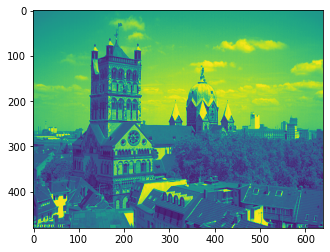

float32


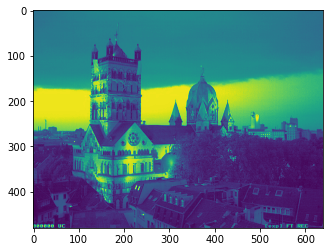

float32


In [ ]:
im1 = cv2.imread(im1)
im1 = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
im1 = cv2.resize(im1,(640,480))
im1 = im1.astype(np.float32)
plt.imshow(im1)
plt.show()
print(im1.dtype)

im2 = cv2.imread(im2)
im2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
im2 = cv2.resize(im2,(640,480))
im2 = im2.astype(np.float32)
plt.imshow(im2)
plt.show()
print(im2.dtype)

In [ ]:
kp1, des1 = model(torch.from_numpy(im1[np.newaxis,np.newaxis,:,:]))
kp2, des2 = model(torch.from_numpy(im2[np.newaxis,np.newaxis,:,:]))

In [ ]:
print(kp1.shape)
print(des1.shape)

torch.Size([1, 65, 60, 80])
torch.Size([1, 256, 60, 80])


In [ ]:
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
knn_matches = matcher.knnMatch(des1, des2, 2)
#-- Filter matches using the Lowe's ratio test
ratio_thresh = 0.7
good_matches = []
for m,n in knn_matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)
#-- Draw matches
img_matches = np.empty((max(im1.shape[0], im2.shape[0]), im1.shape[1]+im2.shape[1], 3), dtype=np.uint8)
cv2.drawMatches(im1, kp1, im2, kp2, good_matches, img_matches, 1, matchColor=-1, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#-- Show detected matches
plt.figure(figsize=(18,36))
plt.imshow(img_matches)

error: OpenCV(4.5.4-dev) :-1: error: (-5:Bad argument) in function 'drawMatches'
> Overload resolution failed:
>  - argument for drawMatches() given by name ('matchColor') and position (7)
>  - argument for drawMatches() given by name ('matchColor') and position (7)
>  - Can't parse 'keypoints1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'keypoints1'. Sequence item with index 0 has a wrong type


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=715a1e20-cf88-4392-be19-7391a8dd0abf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>